In [1]:
import Pkg

Pkg.add("MLDataUtils")
Pkg.add("DelimitedFiles")
Pkg.add("Flux")
Pkg.add("DataFrames")
Pkg.add("LaTeXStrings")

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [8bb1440f] + DelimitedFiles
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [23]:
using ImageCore
using MLDatasets
using LinearAlgebra
using DelimitedFiles
using Flux
using MLDataUtils
using Plots
using Printf
using Statistics
using DataFrames
using LaTeXStrings
using StatsBase

In [87]:
train_x, train_y = FashionMNIST.traindata()
test_x, test_y = FashionMNIST.testdata()

train_x = permutedims(train_x, [3, 2, 1])
test_x = permutedims(test_x, [3, 2, 1])

no_samples = size(train_x)[1]
no_labels = length(unique(train_y))[1];

In [88]:
# Given we are working with an MLP, we will flatten the vectors

train_x = [[train_x[i, :, :]...] for i in 1:no_samples]
test_x = [[test_x[i, :, :]...] for i in 1:size(test_x)[1]];

In [89]:
FashionMNIST.convert2image(FashionMNIST.traintensor(1))

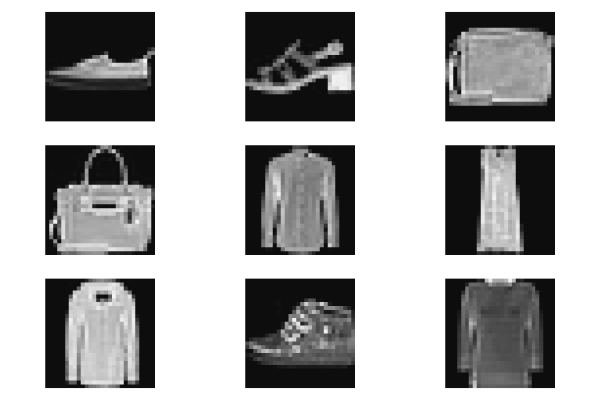

In [90]:
random_samples = rand(1:no_samples, 9);
plt = plot(layout = (3, 3), aspect_ratio = :equal, axis = false)

for (i, sample) in enumerate(random_samples)
    heatmap!(plt, 
        reshape(train_x[sample], 28, 28), 
        subplot = i, 
        yflip = true, 
        color = :grays, 
        colorbar = false, 
        axis = nothing)
end

display(plt)

In [97]:
# We will start by considering a Three Layer MLP 

mutable struct ThreeLayerPerceptron
    W1 ::Matrix{Float64}
    b1 ::Vector{Float64}
    W2 ::Matrix{Float64}
    b2 ::Vector{Float64}
    W3 ::Matrix{Float64}
    b3 ::Vector{Float64}
end

# Define a constructor

ThreeLayerPerceptron(no_hidden_nodes, no_features, no_classes) = ThreeLayerPerceptron(
    randn(no_hidden_nodes, no_features), 
    randn(no_hidden_nodes),
    randn(no_hidden_nodes, no_hidden_nodes),
    randn(no_hidden_nodes),
    randn(no_classes, no_hidden_nodes),
    randn(no_classes))

#Define the helper functions for this network

f(m::ThreeLayerPerceptron, x) = softmax(m.W3 * logistic.(m.W2 * logistic.(m.W1 * x + m.b1) + m.b2) + m.b3)
predict(m::ThreeLayerPerceptron, x) = findmax(f(m, x))[2];
loss(m::ThreeLayerPerceptron, x, y) = -log(f(m, x)[Int(y)])

loss (generic function with 1 method)

In [109]:
#Define helper functions for gradient calculations

function zero(m::ThreeLayerPerceptron)
    gradm = deepcopy(m)
    fill!(gradm.W1, 0)
    fill!(gradm.W2, 0)
    fill!(gradm.W3, 0)
    fill!(gradm.b1, 0)
    fill!(gradm.b2, 0)
    fill!(gradm.b3, 0)
    return gradm
end

function flatten(m::ThreeLayerPerceptron)
    toflatten = (m.W1, m.b1, m.W2, m.b2, m.W3, m.b3) 
    flatvec = vcat([x[:] for x in toflatten]...)
    return flatvec
end

function unflatten!(m::ThreeLayerPerceptron, vec)
    tounflatten = (m.W1, m.b1, m.W2, m.b2, m.W3, m.b3)
    offset = 1
    for parameter in tounflatten
        parameter[:] = vec[offset:offset + length(parameter) - 1]
        offset += length(parameter)
    end
    return m
end

function accuracy(m::ThreeLayerPerceptron, X, y)
    correct = 0
    no_samples = length(y)
    for i in 1:no_samples
        y_pred = predict(m, X[i, :])
        correct += y_pred == y[i]
    end
    acc = correct / no_samples
    return acc
end

logistic(x) = 1 / (1 + exp(-x))
logistic_prime(x) = logistic(x) * (1 - logistic(x))

outer(x, y) = x.*y'

lossprime(m::ThreeLayerPerceptron, x, y) = lossprime!(zero(m), m, x, y)

function lossprime!(gradm, m, x, y)
    
    # Feed Forward
    
    a0 = x
    z1 = m.W1 * a0 + m.b1 
    a1 = logistic.(z1)
    z2 = m.W2 * a1 + m.b2 
    a2 = logistic.(z2)
    z3 = m.W3 * a2 + m.b3 
    a3 = softmax(z3)
    
    #backwards
    
    a3[Int(y)]  -= 1
    error_3 = a3
    error_2 = logistic_prime.(z2) .* m.W3' * error_3
    error_1 = logistic_prime.(z1) .* m.W2' * error_2
    
    gradm.b3 += error_3
    gradm.b2 += error_2
    gradm.b1 += error_1
    
    gradm.W3 += outer(error_3, a2)
    gradm.W2 += outer(error_2, a1)
    gradm.W1 += outer(error_1, a0)
    
    return gradm
    
end


batchify(indices, n) = [indices[i:min(i + n - 1, length(indices)), :] for i in 1:n:length(indices)]

batchify (generic function with 1 method)

In [ ]:
hidden_nodes = [4, 8, 16, 32, 64, 128]
learning_rate = 0.1
batchsize = 16
max_epochs = 1000
max_runs = 20

train_errors = zeros(max_runs, 6)
test_errors = zeros(max_runs, 6)

for h in 1:length(hidden_nodes)
    IJulia.clear_output(true)
    println("Current training model for $(hidden_nodes[h]) hidden nodes\n")
    
    for run in 1:max_runs
    
        mlp = ThreeLayerPerceptron(hidden_nodes[h], 256, no_classes)

        loss_list = []
        training_accuracies = []
        test_accuracies = []

        best_model = mlp
        best_train_accuracy = 0
        best_test_accuracy = 0

        train_indices, test_indices = train_test_split(1:no_samples, true, 0.8)

        for epoch in 1:max_epochs

            loss_value = 0

            for indices_list in batchify(train_indices, batchsize)

                n = length(indices_list)
                gradm = zero(mlp)

                for i in indices_list

                    x_train = X[i, :]
                    y_train = y[i]
                    
                    #compute the loss
                    loss_value = loss(mlp, x_train, y_train)

                    #calculate the gradient
                    lossprime!(gradm, mlp, x_train, y_train)

                end

                #We take a step in the direction of the gradient
                vecm = flatten(mlp)
                vecgm = flatten(gradm)
                vecm .-= learning_rate * vecgm / n
                unflatten!(mlp, vecm)
            end

            training_accuracy = accuracy(mlp, X[train_indices, :], y[train_indices])
            test_accuracy     = accuracy(mlp, X[test_indices, :], y[test_indices])

            @show epoch, training_accuracy, test_accuracy

            append!(training_accuracies, training_accuracy)
            append!(test_accuracies, test_accuracy)
            append!(loss_list, loss_value)

            if test_accuracy > best_test_accuracy
                best_train_accuracy = training_accuracy
                best_test_accuracy = test_accuracy
                best_model = deepcopy(mlp)
            end

            training_accuracy < 1.0 || break
            if epoch > 10 && (test_accuracies[end] - minimum(test_accuracies[end-(10-1):end-1]) < 0.001)
                break
            end
        end
        println("")
        
        test_error = 1 - best_test_accuracy
        test_errors[run, h] = test_error
        
        train_error = 1 - best_train_accuracy
        train_errors[run, h] = train_error
    end
end
MSE_train = dropdims(mean(train_errors, dims = 1), dims = 1)
MSE_test  = dropdims(mean(test_errors, dims = 1), dims = 1)

STD_train = dropdims(std(train_errors, dims = 1), dims = 1)
STD_test  = dropsims(std(test_errors, dims = 1), dims = 1)